In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [44]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
import scipy
from ltcl.datasets.mocap_dataset import MocapTwoSample
from ltcl.modules.srnn_mocap import SRNNSyntheticNS
from ltcl.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from ltcl.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
cfg = load_yaml('../ltcl/configs/mocap.yaml')

In [348]:
num_validation_samples=128
data = MocapTwoSample(directory='/srv/data/ltcl/data/')
# train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(data, batch_size=4500, shuffle=False, pin_memory=True)
# val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [621]:
cfg

{'ROOT': '/srv/data/ltcl/data',
 'LOG': '/srv/data/ltcl/log',
 'DATASET': 'mocap_point_cloud',
 'SPLINE': {'USE_WARM_START': True,
  'TYPE': 'gaussian',
  'STEPS': 5000,
  'LR': 0.001,
  'CUDA': False,
  'BS': 64,
  'LATENT_DIM': 8,
  'BOUND': 5,
  'BINS': 8,
  'ORDER': 'linear',
  'PATH': '/srv/data/ltcl/ckpts/mocap_8.pth'},
 'VAE': {'GPU': [1],
  'CPU': 8,
  'TRAIN_BS': 32,
  'VAL_BS': 128,
  'EPOCHS': 200,
  'N_VAL_SAMPLES': 128,
  'LAG': 2,
  'LENGTH': 4,
  'NCLASS': 12,
  'TRANS_PRIOR': 'NP',
  'LR': 0.001,
  'BETA': 0.1,
  'GAMMA': 1,
  'SIGMA': 1e-06,
  'L1': 0.001,
  'INPUT_DIM': 62,
  'LATENT_DIM': 8,
  'BIAS': False,
  'ENC': {'HIDDEN_DIM': 128},
  'DEC': {'HIDDEN_DIM': 128, 'DIST': 'gaussian'},
  'PIN': True}}

In [385]:
model = SRNNSyntheticNS.load_from_checkpoint('/srv/data/ltcl/log/weiran/mocap/lightning_logs/version_9/checkpoints/epoch=188-step=25136.ckpt',
                                         input_dim=cfg['VAE']['INPUT_DIM'],
                                        length=cfg['VAE']['LENGTH'],
                                        z_dim=cfg['VAE']['LATENT_DIM'], 
                                        lag=cfg['VAE']['LAG'],
                                        nclass=cfg['VAE']['NCLASS'],
                                        hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                                        trans_prior=cfg['VAE']['TRANS_PRIOR'],
                                        bound=cfg['SPLINE']['BOUND'],
                                        count_bins=cfg['SPLINE']['BINS'],
                                        order=cfg['SPLINE']['ORDER'],
                                        beta=cfg['VAE']['BETA'],
                                        gamma=cfg['VAE']['GAMMA'],
                                        sigma=cfg['VAE']['SIGMA'],
                                        lr=cfg['VAE']['LR'],
                                        bias=cfg['VAE']['BIAS'],
                                        use_warm_start=cfg['SPLINE']['USE_WARM_START'],
                                        spline_pth=cfg['SPLINE']['PATH'],
                                        decoder_dist=cfg['VAE']['DEC']['DIST'])

Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow


In [386]:
batch = next(iter(train_loader))
batch_size = batch['s1']['xt'].shape[0]

In [387]:
latent_size = cfg['VAE']['LATENT_DIM']

In [470]:
z, mu, logvar = model.forward(batch['s1'])
mu = mu.view(batch_size, -1, latent_size)

<AxesSubplot:>

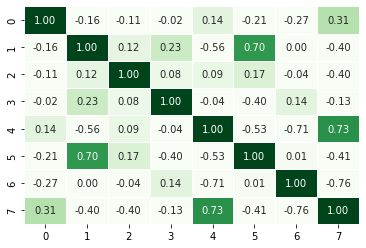

In [389]:
sns.heatmap(np.corrcoef(mu[:,2,:].detach().numpy().T),vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')

In [390]:
zs_flat = z.contiguous().view(-1, model.z_dim)
x_recon = model.dec(zs_flat)
x_recon = x_recon.view(batch_size, -1, model.input_dim)

In [620]:
steps = 100
frame_idx = 10
interpolations = torch.linspace(-8,8,steps)
fixed_frame = mu[frame_idx:frame_idx+1, 0, :].detach()
for latent_idx in range(8):
    x_recon = [ ]
    for val in interpolations:
        new_frame = fixed_frame.clone()
        new_frame[0, latent_idx] = val
        x_recon.append(model.dec(new_frame))
    #     x_recon.append(batch['s1']['xt'][frame_idx,0])
    x_recon = torch.stack(x_recon).squeeze().detach().numpy()
    x_recon = (x_recon * data.std) + data.mean
    np.save('/home/weiran/data/travesal%d'%latent_idx, x_recon)

In [391]:
loss = torch.square(x_recon-batch['s1']['xt']).mean(1).mean(1)*model.input_dim

In [392]:
start = 320
end = 630
start = 0
end = 300

In [393]:
anchors = np.array([[0, 310],
[316, 639],
[645, 1054],
[1060, 1503],
[1509, 2020],
[2026, 2437],
[2443, 2816],
[2822, 3178],
[3184, 3484],
[3490, 3785],
[3791, 4100],
[4106, 4363]])

In [394]:
regime = 4
start, end = anchors[regime]

In [395]:
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [610]:
figure_path = '/home/weiran/figs/'

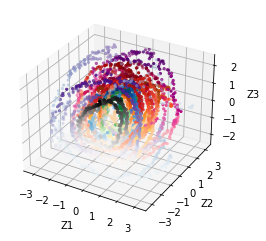

In [617]:
with PdfPages(figure_path + '/mocap_coords.pdf') as pdf:
    ax = plt.axes(projection='3d')
    for regime in range(12):
        start, end = anchors[regime]
        # Data for a three-dimensional line
        xline = z[start:end,0,2].detach().numpy()
        yline = z[start:end,0,3].detach().numpy()
        zline = z[start:end,0,6].detach().numpy()
        ax.scatter3D(xline, yline, zline, c=zline, cmap=cmaps[regime], s=5, label='Trial %d'%(regime+1));
    ax.set_xlabel('Z1')
    ax.set_ylabel('Z2')
    ax.set_zlabel('Z3')
    ax.set_xlim(-3.5,3.5)
    ax.set_ylim(-3.5,3.5)
    ax.set_zlim(-2.5,2.5)
    pdf.savefig(ax.figure, bbox_inches="tight")

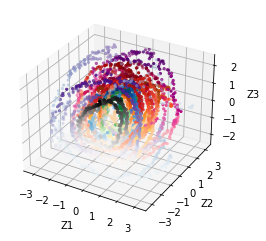

In [458]:
z[:,0].mean(0)

tensor([-0.0101, -0.3023,  0.0363, -0.0800,  0.0208, -0.0132,  0.0008,  0.0061],
       grad_fn=<MeanBackward1>)

In [454]:
logvar[:,0].mean(0)

tensor([-0.0179, -0.6328, -7.4153, -7.1153, -0.1041, -0.1758, -7.2888, -0.0575],
       grad_fn=<MeanBackward1>)

In [596]:
X1 = mu[:,0,[2,3,6]].detach().numpy()
X2 = mu[:,1, [2,3,6]].detach().numpy()
X3 = mu[:,2, [2,3,6]].detach().numpy()

In [597]:
X = np.concatenate((X2.reshape(batch_size,-1), X1.reshape(batch_size,-1)),axis=-1)

In [598]:
from sklearn.linear_model import Lasso, LassoCV

In [599]:
from ltcl.modules.components.pruning import LassoNetRegressor, plot_path

pr_model = LassoNetRegressor(
    hidden_dims=(16,8),
    eps_start=0.1,
    verbose=True,
    device='cpu'
)

In [601]:
masks = [ ] 
for i in range(3):
    y = X3.reshape(batch_size,-1)[:,i]
    path = pr_model.path(X, y)
    mask = torch.cat((path[610].selected.reshape(2,3)[:,0],
                      path[610].selected.reshape(2,3)[:,1],
                      path[610].selected.reshape(2,3)[:,2])).detach().numpy()
    masks.append(mask)

Initialized dense model in 815 epochs, val loss 1.32e-03, regularization 5.15e-01
Lambda = 1.32e-04, selected 6 features in 10 epochs
val_objective 2.48e-03, val_loss 2.41e-03, regularization 5.68e-01
Lambda = 1.35e-04, selected 6 features in 43 epochs
val_objective 1.39e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 1.38e-04, selected 6 features in 10 epochs
val_objective 1.39e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 1.40e-04, selected 6 features in 10 epochs
val_objective 1.39e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 1.43e-04, selected 6 features in 10 epochs
val_objective 1.40e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 1.46e-04, selected 6 features in 10 epochs
val_objective 1.40e-03, val_loss 1.32e-03, regularization 5.83e-01
Lambda = 1.49e-04, selected 6 features in 10 epochs
val_objective 1.40e-03, val_loss 1.32e-03, regularization 5.83e-01
Lambda = 1.52e-04, selected 6 features in 10 epochs
val_objective 1.41e-03, val_loss 

Lambda = 6.45e-04, selected 6 features in 10 epochs
val_objective 1.69e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 6.58e-04, selected 6 features in 10 epochs
val_objective 1.70e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 6.71e-04, selected 6 features in 10 epochs
val_objective 1.71e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 6.85e-04, selected 6 features in 10 epochs
val_objective 1.71e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 6.99e-04, selected 6 features in 10 epochs
val_objective 1.72e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 7.12e-04, selected 6 features in 10 epochs
val_objective 1.73e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 7.27e-04, selected 6 features in 10 epochs
val_objective 1.74e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 7.41e-04, selected 6 features in 10 epochs
val_objective 1.75e-03, val_loss 1.31e-03, regularization 5.83e-01
Lambda = 7.56e-04, selected 6 features in 10 epo

Lambda = 2.58e-03, selected 6 features in 10 epochs
val_objective 2.81e-03, val_loss 1.31e-03, regularization 5.81e-01
Lambda = 2.63e-03, selected 6 features in 10 epochs
val_objective 2.84e-03, val_loss 1.31e-03, regularization 5.81e-01
Lambda = 2.69e-03, selected 6 features in 10 epochs
val_objective 2.87e-03, val_loss 1.31e-03, regularization 5.81e-01
Lambda = 2.74e-03, selected 6 features in 10 epochs
val_objective 2.91e-03, val_loss 1.31e-03, regularization 5.81e-01
Lambda = 2.79e-03, selected 6 features in 10 epochs
val_objective 2.94e-03, val_loss 1.31e-03, regularization 5.81e-01
Lambda = 2.85e-03, selected 6 features in 10 epochs
val_objective 2.97e-03, val_loss 1.31e-03, regularization 5.81e-01
Lambda = 2.91e-03, selected 6 features in 10 epochs
val_objective 3.00e-03, val_loss 1.31e-03, regularization 5.81e-01
Lambda = 2.96e-03, selected 6 features in 10 epochs
val_objective 3.04e-03, val_loss 1.31e-03, regularization 5.80e-01
Lambda = 3.02e-03, selected 6 features in 10 epo

Lambda = 1.05e-02, selected 6 features in 10 epochs
val_objective 7.31e-03, val_loss 1.32e-03, regularization 5.69e-01
Lambda = 1.07e-02, selected 6 features in 10 epochs
val_objective 7.43e-03, val_loss 1.32e-03, regularization 5.69e-01
Lambda = 1.10e-02, selected 6 features in 10 epochs
val_objective 7.54e-03, val_loss 1.32e-03, regularization 5.68e-01
Lambda = 1.12e-02, selected 6 features in 10 epochs
val_objective 7.66e-03, val_loss 1.32e-03, regularization 5.68e-01
Lambda = 1.14e-02, selected 6 features in 10 epochs
val_objective 7.79e-03, val_loss 1.32e-03, regularization 5.68e-01
Lambda = 1.16e-02, selected 6 features in 10 epochs
val_objective 7.91e-03, val_loss 1.32e-03, regularization 5.67e-01
Lambda = 1.19e-02, selected 6 features in 10 epochs
val_objective 8.04e-03, val_loss 1.32e-03, regularization 5.67e-01
Lambda = 1.21e-02, selected 6 features in 10 epochs
val_objective 8.17e-03, val_loss 1.32e-03, regularization 5.67e-01
Lambda = 1.23e-02, selected 6 features in 10 epo

Lambda = 4.38e-02, selected 6 features in 10 epochs
val_objective 2.45e-02, val_loss 1.32e-03, regularization 5.29e-01
Lambda = 4.47e-02, selected 6 features in 10 epochs
val_objective 2.49e-02, val_loss 1.32e-03, regularization 5.28e-01
Lambda = 4.56e-02, selected 6 features in 10 epochs
val_objective 2.53e-02, val_loss 1.32e-03, regularization 5.27e-01
Lambda = 4.65e-02, selected 6 features in 10 epochs
val_objective 2.58e-02, val_loss 1.32e-03, regularization 5.26e-01
Lambda = 4.74e-02, selected 6 features in 10 epochs
val_objective 2.62e-02, val_loss 1.33e-03, regularization 5.24e-01
Lambda = 4.84e-02, selected 6 features in 10 epochs
val_objective 2.66e-02, val_loss 1.33e-03, regularization 5.23e-01
Lambda = 4.93e-02, selected 6 features in 10 epochs
val_objective 2.71e-02, val_loss 1.33e-03, regularization 5.22e-01
Lambda = 5.03e-02, selected 6 features in 10 epochs
val_objective 2.75e-02, val_loss 1.33e-03, regularization 5.21e-01
Lambda = 5.13e-02, selected 6 features in 10 epo

Lambda = 1.75e-01, selected 6 features in 10 epochs
val_objective 6.72e-02, val_loss 1.36e-03, regularization 3.76e-01
Lambda = 1.79e-01, selected 6 features in 10 epochs
val_objective 6.81e-02, val_loss 1.36e-03, regularization 3.73e-01
Lambda = 1.82e-01, selected 6 features in 10 epochs
val_objective 6.91e-02, val_loss 1.37e-03, regularization 3.72e-01
Lambda = 1.86e-01, selected 6 features in 10 epochs
val_objective 7.02e-02, val_loss 1.37e-03, regularization 3.70e-01
Lambda = 1.90e-01, selected 6 features in 10 epochs
val_objective 7.14e-02, val_loss 1.38e-03, regularization 3.69e-01
Lambda = 1.93e-01, selected 6 features in 10 epochs
val_objective 7.26e-02, val_loss 1.38e-03, regularization 3.68e-01
Lambda = 1.97e-01, selected 6 features in 10 epochs
val_objective 7.38e-02, val_loss 1.38e-03, regularization 3.67e-01
Lambda = 2.01e-01, selected 6 features in 10 epochs
val_objective 7.50e-02, val_loss 1.38e-03, regularization 3.66e-01
Lambda = 2.05e-01, selected 6 features in 10 epo

Lambda = 6.87e-01, selected 6 features in 10 epochs
val_objective 1.96e-01, val_loss 1.46e-03, regularization 2.83e-01
Lambda = 7.01e-01, selected 6 features in 10 epochs
val_objective 2.00e-01, val_loss 1.46e-03, regularization 2.83e-01
Lambda = 7.15e-01, selected 6 features in 10 epochs
val_objective 2.04e-01, val_loss 1.46e-03, regularization 2.83e-01
Lambda = 7.29e-01, selected 6 features in 10 epochs
val_objective 2.07e-01, val_loss 1.45e-03, regularization 2.82e-01
Lambda = 7.44e-01, selected 6 features in 10 epochs
val_objective 2.11e-01, val_loss 1.45e-03, regularization 2.82e-01
Lambda = 7.59e-01, selected 6 features in 10 epochs
val_objective 2.15e-01, val_loss 1.45e-03, regularization 2.82e-01
Lambda = 7.74e-01, selected 6 features in 10 epochs
val_objective 2.19e-01, val_loss 1.45e-03, regularization 2.81e-01
Lambda = 7.89e-01, selected 6 features in 10 epochs
val_objective 2.23e-01, val_loss 1.45e-03, regularization 2.81e-01
Lambda = 8.05e-01, selected 6 features in 10 epo

Lambda = 3.77e+00, selected 6 features in 10 epochs
val_objective 8.63e-01, val_loss 1.56e-03, regularization 2.28e-01
Lambda = 3.85e+00, selected 6 features in 10 epochs
val_objective 8.77e-01, val_loss 1.57e-03, regularization 2.27e-01
Lambda = 3.93e+00, selected 6 features in 10 epochs
val_objective 8.91e-01, val_loss 1.57e-03, regularization 2.27e-01
Lambda = 4.00e+00, selected 6 features in 10 epochs
val_objective 9.05e-01, val_loss 1.58e-03, regularization 2.26e-01
Lambda = 4.08e+00, selected 6 features in 10 epochs
val_objective 9.20e-01, val_loss 1.58e-03, regularization 2.25e-01
Lambda = 4.17e+00, selected 6 features in 10 epochs
val_objective 9.34e-01, val_loss 1.59e-03, regularization 2.24e-01
Lambda = 4.25e+00, selected 6 features in 10 epochs
val_objective 9.49e-01, val_loss 1.59e-03, regularization 2.23e-01
Lambda = 4.33e+00, selected 6 features in 10 epochs
val_objective 9.64e-01, val_loss 1.60e-03, regularization 2.22e-01
Lambda = 4.42e+00, selected 6 features in 10 epo

Lambda = 1.54e+01, selected 6 features in 10 epochs
val_objective 2.15e+00, val_loss 2.11e-03, regularization 1.40e-01
Lambda = 1.57e+01, selected 6 features in 10 epochs
val_objective 2.18e+00, val_loss 2.14e-03, regularization 1.38e-01
Lambda = 1.60e+01, selected 6 features in 90 epochs
val_objective 2.02e+00, val_loss 2.34e-03, regularization 1.26e-01
Lambda = 1.63e+01, selected 6 features in 10 epochs
val_objective 2.04e+00, val_loss 2.33e-03, regularization 1.25e-01
Lambda = 1.67e+01, selected 6 features in 10 epochs
val_objective 2.07e+00, val_loss 2.33e-03, regularization 1.24e-01
Lambda = 1.70e+01, selected 6 features in 20 epochs
val_objective 2.06e+00, val_loss 2.33e-03, regularization 1.21e-01
Lambda = 1.73e+01, selected 6 features in 20 epochs
val_objective 2.06e+00, val_loss 2.33e-03, regularization 1.19e-01
Lambda = 1.77e+01, selected 6 features in 20 epochs
val_objective 2.06e+00, val_loss 2.37e-03, regularization 1.17e-01
Lambda = 1.80e+01, selected 6 features in 100 ep

Lambda = 7.50e+01, selected 1 features in 10 epochs
val_objective 1.26e+00, val_loss 5.84e-03, regularization 1.68e-02
Lambda = 7.65e+01, selected 1 features in 20 epochs
val_objective 1.26e+00, val_loss 5.92e-03, regularization 1.64e-02
Lambda = 7.81e+01, selected 1 features in 20 epochs
val_objective 1.26e+00, val_loss 5.98e-03, regularization 1.61e-02
Lambda = 7.96e+01, selected 1 features in 20 epochs
val_objective 1.26e+00, val_loss 6.06e-03, regularization 1.58e-02
Lambda = 8.12e+01, selected 1 features in 20 epochs
val_objective 1.26e+00, val_loss 6.12e-03, regularization 1.55e-02
Lambda = 8.28e+01, selected 1 features in 30 epochs
val_objective 1.25e+00, val_loss 6.20e-03, regularization 1.50e-02
Lambda = 8.45e+01, selected 1 features in 20 epochs
val_objective 1.25e+00, val_loss 6.27e-03, regularization 1.47e-02
Lambda = 8.62e+01, selected 1 features in 20 epochs
val_objective 1.25e+00, val_loss 6.35e-03, regularization 1.44e-02
Lambda = 8.79e+01, selected 1 features in 20 epo

Lambda = 4.12e+02, selected 1 features in 10 epochs
val_objective 2.03e+00, val_loss 1.22e-02, regularization 4.90e-03
Lambda = 4.20e+02, selected 1 features in 10 epochs
val_objective 2.05e+00, val_loss 1.24e-02, regularization 4.85e-03
Lambda = 4.29e+02, selected 1 features in 10 epochs
val_objective 2.07e+00, val_loss 1.26e-02, regularization 4.80e-03
Lambda = 4.37e+02, selected 1 features in 20 epochs
val_objective 2.08e+00, val_loss 1.23e-02, regularization 4.72e-03
Lambda = 4.46e+02, selected 1 features in 16 epochs
val_objective 2.08e+00, val_loss 1.23e-02, regularization 4.64e-03
Lambda = 4.55e+02, selected 1 features in 16 epochs
val_objective 2.09e+00, val_loss 1.26e-02, regularization 4.56e-03
Lambda = 4.64e+02, selected 1 features in 17 epochs
val_objective 2.09e+00, val_loss 1.26e-02, regularization 4.48e-03
Lambda = 4.73e+02, selected 1 features in 16 epochs
val_objective 2.10e+00, val_loss 1.27e-02, regularization 4.41e-03
Lambda = 4.83e+02, selected 1 features in 16 epo

Lambda = 2.13e+03, selected 1 features in 11 epochs
val_objective 4.19e+00, val_loss 5.08e-02, regularization 1.94e-03
Lambda = 2.17e+03, selected 1 features in 11 epochs
val_objective 4.22e+00, val_loss 5.19e-02, regularization 1.92e-03
Lambda = 2.22e+03, selected 1 features in 11 epochs
val_objective 4.26e+00, val_loss 5.31e-02, regularization 1.90e-03
Lambda = 2.26e+03, selected 1 features in 11 epochs
val_objective 4.30e+00, val_loss 5.43e-02, regularization 1.88e-03
Lambda = 2.31e+03, selected 1 features in 11 epochs
val_objective 4.34e+00, val_loss 5.55e-02, regularization 1.86e-03
Lambda = 2.35e+03, selected 1 features in 11 epochs
val_objective 4.38e+00, val_loss 5.67e-02, regularization 1.84e-03
Lambda = 2.40e+03, selected 1 features in 11 epochs
val_objective 4.42e+00, val_loss 5.79e-02, regularization 1.82e-03
Lambda = 2.45e+03, selected 1 features in 11 epochs
val_objective 4.46e+00, val_loss 5.90e-02, regularization 1.80e-03
Lambda = 2.50e+03, selected 1 features in 11 epo

Lambda = 1.02e+04, selected 1 features in 11 epochs
val_objective 7.33e+00, val_loss 2.83e-01, regularization 6.92e-04
Lambda = 1.04e+04, selected 1 features in 11 epochs
val_objective 7.40e+00, val_loss 2.86e-01, regularization 6.84e-04
Lambda = 1.06e+04, selected 1 features in 11 epochs
val_objective 7.47e+00, val_loss 2.88e-01, regularization 6.77e-04
Lambda = 1.08e+04, selected 1 features in 11 epochs
val_objective 7.54e+00, val_loss 2.90e-01, regularization 6.70e-04
Lambda = 1.10e+04, selected 1 features in 11 epochs
val_objective 7.62e+00, val_loss 2.91e-01, regularization 6.64e-04
Lambda = 1.12e+04, selected 1 features in 11 epochs
val_objective 7.70e+00, val_loss 2.92e-01, regularization 6.58e-04
Lambda = 1.15e+04, selected 1 features in 11 epochs
val_objective 7.79e+00, val_loss 2.93e-01, regularization 6.54e-04
Lambda = 1.17e+04, selected 1 features in 11 epochs
val_objective 7.90e+00, val_loss 2.92e-01, regularization 6.50e-04
Lambda = 1.19e+04, selected 1 features in 11 epo

Lambda = 4.26e-04, selected 6 features in 10 epochs
val_objective 1.17e-02, val_loss 1.12e-02, regularization 1.19e+00
Lambda = 4.34e-04, selected 6 features in 10 epochs
val_objective 1.16e-02, val_loss 1.11e-02, regularization 1.19e+00
Lambda = 4.43e-04, selected 6 features in 10 epochs
val_objective 1.16e-02, val_loss 1.11e-02, regularization 1.19e+00
Lambda = 4.52e-04, selected 6 features in 10 epochs
val_objective 1.15e-02, val_loss 1.10e-02, regularization 1.19e+00
Lambda = 4.61e-04, selected 6 features in 10 epochs
val_objective 1.15e-02, val_loss 1.09e-02, regularization 1.19e+00
Lambda = 4.70e-04, selected 6 features in 10 epochs
val_objective 1.14e-02, val_loss 1.09e-02, regularization 1.19e+00
Lambda = 4.79e-04, selected 6 features in 10 epochs
val_objective 1.14e-02, val_loss 1.08e-02, regularization 1.19e+00
Lambda = 4.89e-04, selected 6 features in 10 epochs
val_objective 1.13e-02, val_loss 1.08e-02, regularization 1.19e+00
Lambda = 4.99e-04, selected 6 features in 10 epo

Lambda = 2.16e-03, selected 6 features in 10 epochs
val_objective 9.48e-03, val_loss 6.96e-03, regularization 1.17e+00
Lambda = 2.20e-03, selected 6 features in 10 epochs
val_objective 9.52e-03, val_loss 6.95e-03, regularization 1.17e+00
Lambda = 2.25e-03, selected 6 features in 10 epochs
val_objective 9.55e-03, val_loss 6.94e-03, regularization 1.17e+00
Lambda = 2.29e-03, selected 6 features in 10 epochs
val_objective 9.59e-03, val_loss 6.92e-03, regularization 1.17e+00
Lambda = 2.34e-03, selected 6 features in 10 epochs
val_objective 9.63e-03, val_loss 6.91e-03, regularization 1.16e+00
Lambda = 2.38e-03, selected 6 features in 10 epochs
val_objective 9.67e-03, val_loss 6.89e-03, regularization 1.16e+00
Lambda = 2.43e-03, selected 6 features in 10 epochs
val_objective 9.71e-03, val_loss 6.88e-03, regularization 1.16e+00
Lambda = 2.48e-03, selected 6 features in 10 epochs
val_objective 9.76e-03, val_loss 6.87e-03, regularization 1.16e+00
Lambda = 2.53e-03, selected 6 features in 10 epo

Lambda = 1.16e-02, selected 6 features in 10 epochs
val_objective 1.94e-02, val_loss 5.98e-03, regularization 1.16e+00
Lambda = 1.19e-02, selected 6 features in 10 epochs
val_objective 1.97e-02, val_loss 5.97e-03, regularization 1.16e+00
Lambda = 1.21e-02, selected 6 features in 10 epochs
val_objective 1.99e-02, val_loss 5.96e-03, regularization 1.16e+00
Lambda = 1.23e-02, selected 6 features in 10 epochs
val_objective 2.02e-02, val_loss 5.95e-03, regularization 1.16e+00
Lambda = 1.26e-02, selected 6 features in 10 epochs
val_objective 2.05e-02, val_loss 5.94e-03, regularization 1.16e+00
Lambda = 1.28e-02, selected 6 features in 10 epochs
val_objective 2.08e-02, val_loss 5.93e-03, regularization 1.16e+00
Lambda = 1.31e-02, selected 6 features in 10 epochs
val_objective 2.10e-02, val_loss 5.92e-03, regularization 1.16e+00
Lambda = 1.33e-02, selected 6 features in 10 epochs
val_objective 2.13e-02, val_loss 5.91e-03, regularization 1.15e+00
Lambda = 1.36e-02, selected 6 features in 10 epo

Lambda = 4.74e-02, selected 6 features in 10 epochs
val_objective 5.98e-02, val_loss 5.37e-03, regularization 1.15e+00
Lambda = 4.84e-02, selected 6 features in 10 epochs
val_objective 6.08e-02, val_loss 5.36e-03, regularization 1.15e+00
Lambda = 4.93e-02, selected 6 features in 10 epochs
val_objective 6.19e-02, val_loss 5.35e-03, regularization 1.15e+00
Lambda = 5.03e-02, selected 6 features in 10 epochs
val_objective 6.31e-02, val_loss 5.34e-03, regularization 1.15e+00
Lambda = 5.13e-02, selected 6 features in 10 epochs
val_objective 6.42e-02, val_loss 5.33e-03, regularization 1.15e+00
Lambda = 5.23e-02, selected 6 features in 10 epochs
val_objective 6.54e-02, val_loss 5.32e-03, regularization 1.15e+00
Lambda = 5.34e-02, selected 6 features in 10 epochs
val_objective 6.65e-02, val_loss 5.32e-03, regularization 1.15e+00
Lambda = 5.45e-02, selected 6 features in 10 epochs
val_objective 6.77e-02, val_loss 5.31e-03, regularization 1.15e+00
Lambda = 5.55e-02, selected 6 features in 10 epo

Lambda = 2.55e-01, selected 6 features in 10 epochs
val_objective 2.93e-01, val_loss 4.90e-03, regularization 1.13e+00
Lambda = 2.60e-01, selected 6 features in 10 epochs
val_objective 2.98e-01, val_loss 4.90e-03, regularization 1.13e+00
Lambda = 2.65e-01, selected 6 features in 10 epochs
val_objective 3.04e-01, val_loss 4.90e-03, regularization 1.13e+00
Lambda = 2.71e-01, selected 6 features in 10 epochs
val_objective 3.10e-01, val_loss 4.90e-03, regularization 1.13e+00
Lambda = 2.76e-01, selected 6 features in 10 epochs
val_objective 3.16e-01, val_loss 4.90e-03, regularization 1.13e+00
Lambda = 2.82e-01, selected 6 features in 10 epochs
val_objective 3.22e-01, val_loss 4.90e-03, regularization 1.13e+00
Lambda = 2.87e-01, selected 6 features in 10 epochs
val_objective 3.28e-01, val_loss 4.90e-03, regularization 1.13e+00
Lambda = 2.93e-01, selected 6 features in 10 epochs
val_objective 3.35e-01, val_loss 4.90e-03, regularization 1.12e+00
Lambda = 2.99e-01, selected 6 features in 10 epo

Lambda = 1.00e+00, selected 6 features in 10 epochs
val_objective 1.08e+00, val_loss 6.23e-03, regularization 1.08e+00
Lambda = 1.02e+00, selected 6 features in 10 epochs
val_objective 1.10e+00, val_loss 6.30e-03, regularization 1.08e+00
Lambda = 1.04e+00, selected 6 features in 10 epochs
val_objective 1.12e+00, val_loss 6.38e-03, regularization 1.07e+00
Lambda = 1.06e+00, selected 6 features in 10 epochs
val_objective 1.15e+00, val_loss 6.46e-03, regularization 1.07e+00
Lambda = 1.08e+00, selected 6 features in 10 epochs
val_objective 1.17e+00, val_loss 6.53e-03, regularization 1.07e+00
Lambda = 1.10e+00, selected 6 features in 10 epochs
val_objective 1.19e+00, val_loss 6.62e-03, regularization 1.07e+00
Lambda = 1.13e+00, selected 6 features in 10 epochs
val_objective 1.21e+00, val_loss 6.70e-03, regularization 1.07e+00
Lambda = 1.15e+00, selected 6 features in 10 epochs
val_objective 1.23e+00, val_loss 6.79e-03, regularization 1.07e+00
Lambda = 1.17e+00, selected 6 features in 10 epo

Lambda = 4.00e+00, selected 6 features in 10 epochs
val_objective 3.55e+00, val_loss 3.50e-02, regularization 8.79e-01
Lambda = 4.08e+00, selected 6 features in 10 epochs
val_objective 3.60e+00, val_loss 3.62e-02, regularization 8.74e-01
Lambda = 4.16e+00, selected 6 features in 10 epochs
val_objective 3.65e+00, val_loss 3.75e-02, regularization 8.68e-01
Lambda = 4.25e+00, selected 6 features in 10 epochs
val_objective 3.70e+00, val_loss 3.88e-02, regularization 8.63e-01
Lambda = 4.33e+00, selected 6 features in 10 epochs
val_objective 3.75e+00, val_loss 4.02e-02, regularization 8.57e-01
Lambda = 4.42e+00, selected 6 features in 10 epochs
val_objective 3.80e+00, val_loss 4.17e-02, regularization 8.51e-01
Lambda = 4.51e+00, selected 6 features in 10 epochs
val_objective 3.85e+00, val_loss 4.33e-02, regularization 8.44e-01
Lambda = 4.60e+00, selected 6 features in 10 epochs
val_objective 3.90e+00, val_loss 4.50e-02, regularization 8.38e-01
Lambda = 4.69e+00, selected 6 features in 10 epo

Lambda = 2.15e+01, selected 2 features in 10 epochs
val_objective 9.62e-01, val_loss 1.79e-02, regularization 4.38e-02
Lambda = 2.20e+01, selected 2 features in 10 epochs
val_objective 9.72e-01, val_loss 1.78e-02, regularization 4.34e-02
Lambda = 2.24e+01, selected 2 features in 10 epochs
val_objective 9.81e-01, val_loss 1.77e-02, regularization 4.30e-02
Lambda = 2.29e+01, selected 2 features in 20 epochs
val_objective 9.80e-01, val_loss 1.74e-02, regularization 4.21e-02
Lambda = 2.33e+01, selected 2 features in 30 epochs
val_objective 9.70e-01, val_loss 1.71e-02, regularization 4.09e-02
Lambda = 2.38e+01, selected 2 features in 10 epochs
val_objective 9.79e-01, val_loss 1.70e-02, regularization 4.05e-02
Lambda = 2.43e+01, selected 2 features in 20 epochs
val_objective 9.79e-01, val_loss 1.68e-02, regularization 3.96e-02
Lambda = 2.47e+01, selected 2 features in 30 epochs
val_objective 9.68e-01, val_loss 1.66e-02, regularization 3.84e-02
Lambda = 2.52e+01, selected 2 features in 60 epo

Lambda = 1.05e+02, selected 1 features in 10 epochs
val_objective 1.26e+00, val_loss 1.22e-02, regularization 1.18e-02
Lambda = 1.07e+02, selected 1 features in 20 epochs
val_objective 1.26e+00, val_loss 1.20e-02, regularization 1.16e-02
Lambda = 1.09e+02, selected 1 features in 100 epochs
val_objective 1.13e+00, val_loss 8.98e-03, regularization 1.03e-02
Lambda = 1.11e+02, selected 1 features in 62 epochs
val_objective 1.07e+00, val_loss 9.38e-03, regularization 9.56e-03
Lambda = 1.14e+02, selected 1 features in 10 epochs
val_objective 1.09e+00, val_loss 9.76e-03, regularization 9.47e-03
Lambda = 1.16e+02, selected 1 features in 10 epochs
val_objective 1.10e+00, val_loss 1.01e-02, regularization 9.38e-03
Lambda = 1.18e+02, selected 1 features in 10 epochs
val_objective 1.11e+00, val_loss 1.03e-02, regularization 9.31e-03
Lambda = 1.21e+02, selected 1 features in 10 epochs
val_objective 1.13e+00, val_loss 1.05e-02, regularization 9.24e-03
Lambda = 1.23e+02, selected 1 features in 10 ep

Lambda = 4.92e+02, selected 2 features in 13 epochs
val_objective 2.37e+00, val_loss 1.67e-02, regularization 4.79e-03
Lambda = 5.02e+02, selected 2 features in 10 epochs
val_objective 2.41e+00, val_loss 1.69e-02, regularization 4.76e-03
Lambda = 5.12e+02, selected 2 features in 10 epochs
val_objective 2.44e+00, val_loss 1.73e-02, regularization 4.73e-03
Lambda = 5.22e+02, selected 2 features in 12 epochs
val_objective 2.46e+00, val_loss 1.81e-02, regularization 4.68e-03
Lambda = 5.33e+02, selected 2 features in 10 epochs
val_objective 2.50e+00, val_loss 1.83e-02, regularization 4.65e-03
Lambda = 5.43e+02, selected 2 features in 10 epochs
val_objective 2.53e+00, val_loss 1.87e-02, regularization 4.62e-03
Lambda = 5.54e+02, selected 2 features in 10 epochs
val_objective 2.56e+00, val_loss 1.93e-02, regularization 4.58e-03
Lambda = 5.65e+02, selected 2 features in 10 epochs
val_objective 2.59e+00, val_loss 1.98e-02, regularization 4.55e-03
Lambda = 5.77e+02, selected 2 features in 10 epo

Lambda = 2.40e+03, selected 2 features in 11 epochs
val_objective 5.57e+00, val_loss 9.54e-02, regularization 2.28e-03
Lambda = 2.45e+03, selected 2 features in 11 epochs
val_objective 5.62e+00, val_loss 9.72e-02, regularization 2.25e-03
Lambda = 2.50e+03, selected 2 features in 11 epochs
val_objective 5.67e+00, val_loss 9.87e-02, regularization 2.23e-03
Lambda = 2.55e+03, selected 2 features in 11 epochs
val_objective 5.72e+00, val_loss 1.01e-01, regularization 2.21e-03
Lambda = 2.60e+03, selected 2 features in 11 epochs
val_objective 5.77e+00, val_loss 1.03e-01, regularization 2.18e-03
Lambda = 2.65e+03, selected 2 features in 11 epochs
val_objective 5.82e+00, val_loss 1.05e-01, regularization 2.16e-03
Lambda = 2.70e+03, selected 2 features in 11 epochs
val_objective 5.86e+00, val_loss 1.07e-01, regularization 2.13e-03
Lambda = 2.76e+03, selected 2 features in 11 epochs
val_objective 5.91e+00, val_loss 1.09e-01, regularization 2.10e-03
Lambda = 2.81e+03, selected 2 features in 11 epo

Lambda = 1.02e+04, selected 0 features in 13 epochs
val_objective 1.33e+00, val_loss 1.33e+00, regularization 0.00e+00
Initialized dense model in 1000 epochs, val loss 2.64e-03, regularization 2.64e-01
Lambda = 2.64e-04, selected 6 features in 10 epochs
val_objective 1.66e-02, val_loss 1.65e-02, regularization 2.64e-01
Lambda = 2.69e-04, selected 6 features in 10 epochs
val_objective 7.79e+00, val_loss 7.79e+00, regularization 2.60e-01
Lambda = 2.75e-04, selected 6 features in 100 epochs
val_objective 3.10e-02, val_loss 3.09e-02, regularization 4.97e-01
Lambda = 2.80e-04, selected 6 features in 100 epochs
val_objective 4.88e-03, val_loss 4.71e-03, regularization 6.00e-01
Lambda = 2.86e-04, selected 6 features in 97 epochs
val_objective 3.67e-03, val_loss 3.48e-03, regularization 6.45e-01
Lambda = 2.91e-04, selected 6 features in 10 epochs
val_objective 3.65e-03, val_loss 3.46e-03, regularization 6.48e-01
Lambda = 2.97e-04, selected 6 features in 10 epochs
val_objective 3.64e-03, val_lo

Lambda = 1.29e-03, selected 6 features in 10 epochs
val_objective 3.88e-03, val_loss 2.95e-03, regularization 7.25e-01
Lambda = 1.31e-03, selected 6 features in 10 epochs
val_objective 3.90e-03, val_loss 2.95e-03, regularization 7.25e-01
Lambda = 1.34e-03, selected 6 features in 10 epochs
val_objective 3.92e-03, val_loss 2.94e-03, regularization 7.26e-01
Lambda = 1.37e-03, selected 6 features in 10 epochs
val_objective 3.93e-03, val_loss 2.94e-03, regularization 7.26e-01
Lambda = 1.39e-03, selected 6 features in 10 epochs
val_objective 3.95e-03, val_loss 2.94e-03, regularization 7.26e-01
Lambda = 1.42e-03, selected 6 features in 10 epochs
val_objective 3.97e-03, val_loss 2.94e-03, regularization 7.26e-01
Lambda = 1.45e-03, selected 6 features in 10 epochs
val_objective 3.99e-03, val_loss 2.93e-03, regularization 7.27e-01
Lambda = 1.48e-03, selected 6 features in 10 epochs
val_objective 4.00e-03, val_loss 2.93e-03, regularization 7.27e-01
Lambda = 1.51e-03, selected 6 features in 10 epo

Lambda = 6.93e-03, selected 6 features in 10 epochs
val_objective 7.87e-03, val_loss 2.82e-03, regularization 7.28e-01
Lambda = 7.07e-03, selected 6 features in 10 epochs
val_objective 7.96e-03, val_loss 2.82e-03, regularization 7.28e-01
Lambda = 7.21e-03, selected 6 features in 10 epochs
val_objective 8.07e-03, val_loss 2.82e-03, regularization 7.28e-01
Lambda = 7.35e-03, selected 6 features in 10 epochs
val_objective 8.17e-03, val_loss 2.82e-03, regularization 7.27e-01
Lambda = 7.50e-03, selected 6 features in 10 epochs
val_objective 8.27e-03, val_loss 2.82e-03, regularization 7.27e-01
Lambda = 7.65e-03, selected 6 features in 10 epochs
val_objective 8.38e-03, val_loss 2.82e-03, regularization 7.27e-01
Lambda = 7.80e-03, selected 6 features in 10 epochs
val_objective 8.49e-03, val_loss 2.82e-03, regularization 7.27e-01
Lambda = 7.96e-03, selected 6 features in 10 epochs
val_objective 8.60e-03, val_loss 2.82e-03, regularization 7.26e-01
Lambda = 8.12e-03, selected 6 features in 10 epo

Lambda = 3.73e-02, selected 6 features in 10 epochs
val_objective 2.78e-02, val_loss 2.77e-03, regularization 6.71e-01
Lambda = 3.80e-02, selected 6 features in 10 epochs
val_objective 2.82e-02, val_loss 2.76e-03, regularization 6.69e-01
Lambda = 3.88e-02, selected 6 features in 10 epochs
val_objective 2.87e-02, val_loss 2.76e-03, regularization 6.68e-01
Lambda = 3.96e-02, selected 6 features in 10 epochs
val_objective 2.91e-02, val_loss 2.76e-03, regularization 6.66e-01
Lambda = 4.04e-02, selected 6 features in 10 epochs
val_objective 2.96e-02, val_loss 2.76e-03, regularization 6.65e-01
Lambda = 4.12e-02, selected 6 features in 10 epochs
val_objective 3.01e-02, val_loss 2.76e-03, regularization 6.63e-01
Lambda = 4.20e-02, selected 6 features in 10 epochs
val_objective 3.05e-02, val_loss 2.76e-03, regularization 6.62e-01
Lambda = 4.28e-02, selected 6 features in 10 epochs
val_objective 3.10e-02, val_loss 2.76e-03, regularization 6.60e-01
Lambda = 4.37e-02, selected 6 features in 10 epo

Lambda = 1.46e-01, selected 6 features in 10 epochs
val_objective 7.88e-02, val_loss 2.70e-03, regularization 5.20e-01
Lambda = 1.49e-01, selected 6 features in 10 epochs
val_objective 7.98e-02, val_loss 2.70e-03, regularization 5.17e-01
Lambda = 1.52e-01, selected 6 features in 10 epochs
val_objective 8.08e-02, val_loss 2.70e-03, regularization 5.13e-01
Lambda = 1.55e-01, selected 6 features in 10 epochs
val_objective 8.18e-02, val_loss 2.69e-03, regularization 5.09e-01
Lambda = 1.58e-01, selected 6 features in 10 epochs
val_objective 8.27e-02, val_loss 2.69e-03, regularization 5.06e-01
Lambda = 1.61e-01, selected 6 features in 10 epochs
val_objective 8.37e-02, val_loss 2.69e-03, regularization 5.02e-01
Lambda = 1.65e-01, selected 6 features in 10 epochs
val_objective 8.47e-02, val_loss 2.69e-03, regularization 4.98e-01
Lambda = 1.68e-01, selected 6 features in 10 epochs
val_objective 8.57e-02, val_loss 2.69e-03, regularization 4.94e-01
Lambda = 1.71e-01, selected 6 features in 10 epo

Lambda = 5.73e-01, selected 6 features in 40 epochs
val_objective 9.74e-02, val_loss 3.97e-03, regularization 1.63e-01
Lambda = 5.85e-01, selected 5 features in 30 epochs
val_objective 9.63e-02, val_loss 4.04e-03, regularization 1.58e-01
Lambda = 5.97e-01, selected 5 features in 30 epochs
val_objective 9.52e-02, val_loss 4.10e-03, regularization 1.53e-01
Lambda = 6.09e-01, selected 5 features in 30 epochs
val_objective 9.40e-02, val_loss 4.17e-03, regularization 1.48e-01
Lambda = 6.21e-01, selected 5 features in 39 epochs
val_objective 9.19e-02, val_loss 4.26e-03, regularization 1.41e-01
Lambda = 6.33e-01, selected 5 features in 50 epochs
val_objective 8.89e-02, val_loss 4.36e-03, regularization 1.34e-01
Lambda = 6.46e-01, selected 5 features in 59 epochs
val_objective 8.51e-02, val_loss 4.48e-03, regularization 1.25e-01
Lambda = 6.59e-01, selected 5 features in 58 epochs
val_objective 8.14e-02, val_loss 4.60e-03, regularization 1.17e-01
Lambda = 6.72e-01, selected 5 features in 78 epo

Lambda = 2.43e+00, selected 5 features in 10 epochs
val_objective 5.69e-02, val_loss 4.44e-03, regularization 2.16e-02
Lambda = 2.48e+00, selected 5 features in 10 epochs
val_objective 5.75e-02, val_loss 4.43e-03, regularization 2.14e-02
Lambda = 2.53e+00, selected 5 features in 10 epochs
val_objective 5.81e-02, val_loss 4.43e-03, regularization 2.12e-02
Lambda = 2.58e+00, selected 5 features in 10 epochs
val_objective 5.86e-02, val_loss 4.43e-03, regularization 2.10e-02
Lambda = 2.63e+00, selected 5 features in 10 epochs
val_objective 5.92e-02, val_loss 4.44e-03, regularization 2.08e-02
Lambda = 2.69e+00, selected 5 features in 10 epochs
val_objective 5.98e-02, val_loss 4.43e-03, regularization 2.06e-02
Lambda = 2.74e+00, selected 5 features in 100 epochs
val_objective 5.07e-02, val_loss 4.31e-03, regularization 1.69e-02
Lambda = 2.80e+00, selected 5 features in 100 epochs
val_objective 3.94e-02, val_loss 4.24e-03, regularization 1.26e-02
Lambda = 2.85e+00, selected 5 features in 100 

Lambda = 9.73e+00, selected 5 features in 10 epochs
val_objective 3.21e-02, val_loss 3.40e-03, regularization 2.95e-03
Lambda = 9.93e+00, selected 5 features in 10 epochs
val_objective 3.27e-02, val_loss 3.40e-03, regularization 2.95e-03
Lambda = 1.01e+01, selected 5 features in 10 epochs
val_objective 3.33e-02, val_loss 3.39e-03, regularization 2.95e-03
Lambda = 1.03e+01, selected 5 features in 10 epochs
val_objective 3.38e-02, val_loss 3.38e-03, regularization 2.95e-03
Lambda = 1.05e+01, selected 5 features in 10 epochs
val_objective 3.44e-02, val_loss 3.38e-03, regularization 2.95e-03
Lambda = 1.07e+01, selected 5 features in 10 epochs
val_objective 3.51e-02, val_loss 3.37e-03, regularization 2.95e-03
Lambda = 1.10e+01, selected 5 features in 10 epochs
val_objective 3.57e-02, val_loss 3.37e-03, regularization 2.95e-03
Lambda = 1.12e+01, selected 5 features in 10 epochs
val_objective 3.63e-02, val_loss 3.36e-03, regularization 2.95e-03
Lambda = 1.14e+01, selected 5 features in 10 epo

Lambda = 3.89e+01, selected 3 features in 10 epochs
val_objective 1.17e-01, val_loss 3.12e-03, regularization 2.92e-03
Lambda = 3.97e+01, selected 3 features in 10 epochs
val_objective 1.19e-01, val_loss 3.11e-03, regularization 2.92e-03
Lambda = 4.05e+01, selected 3 features in 10 epochs
val_objective 1.21e-01, val_loss 3.11e-03, regularization 2.92e-03
Lambda = 4.13e+01, selected 3 features in 10 epochs
val_objective 1.24e-01, val_loss 3.11e-03, regularization 2.92e-03
Lambda = 4.21e+01, selected 3 features in 10 epochs
val_objective 1.26e-01, val_loss 3.11e-03, regularization 2.92e-03
Lambda = 4.30e+01, selected 3 features in 10 epochs
val_objective 1.28e-01, val_loss 3.10e-03, regularization 2.92e-03
Lambda = 4.38e+01, selected 3 features in 10 epochs
val_objective 1.31e-01, val_loss 3.10e-03, regularization 2.91e-03
Lambda = 4.47e+01, selected 3 features in 10 epochs
val_objective 1.33e-01, val_loss 3.10e-03, regularization 2.91e-03
Lambda = 4.56e+01, selected 3 features in 10 epo

Lambda = 2.10e+02, selected 3 features in 10 epochs
val_objective 5.78e-01, val_loss 4.35e-03, regularization 2.74e-03
Lambda = 2.14e+02, selected 3 features in 11 epochs
val_objective 5.87e-01, val_loss 4.63e-03, regularization 2.73e-03
Lambda = 2.18e+02, selected 3 features in 10 epochs
val_objective 6.00e-01, val_loss 4.47e-03, regularization 2.73e-03
Lambda = 2.22e+02, selected 3 features in 11 epochs
val_objective 6.09e-01, val_loss 4.74e-03, regularization 2.72e-03
Lambda = 2.27e+02, selected 3 features in 10 epochs
val_objective 6.22e-01, val_loss 4.60e-03, regularization 2.72e-03
Lambda = 2.31e+02, selected 3 features in 11 epochs
val_objective 6.32e-01, val_loss 4.87e-03, regularization 2.71e-03
Lambda = 2.36e+02, selected 3 features in 10 epochs
val_objective 6.45e-01, val_loss 4.73e-03, regularization 2.71e-03
Lambda = 2.41e+02, selected 3 features in 11 epochs
val_objective 6.55e-01, val_loss 5.00e-03, regularization 2.70e-03
Lambda = 2.46e+02, selected 3 features in 10 epo

Lambda = 1.06e+03, selected 1 features in 11 epochs
val_objective 2.43e+00, val_loss 1.50e-02, regularization 2.27e-03
Lambda = 1.08e+03, selected 1 features in 11 epochs
val_objective 2.47e+00, val_loss 1.55e-02, regularization 2.26e-03
Lambda = 1.11e+03, selected 1 features in 11 epochs
val_objective 2.49e+00, val_loss 1.70e-02, regularization 2.24e-03
Lambda = 1.13e+03, selected 1 features in 11 epochs
val_objective 2.52e+00, val_loss 1.88e-02, regularization 2.22e-03
Lambda = 1.15e+03, selected 1 features in 11 epochs
val_objective 2.58e+00, val_loss 1.74e-02, regularization 2.23e-03
Lambda = 1.17e+03, selected 1 features in 11 epochs
val_objective 2.59e+00, val_loss 2.05e-02, regularization 2.19e-03
Lambda = 1.20e+03, selected 1 features in 11 epochs
val_objective 2.66e+00, val_loss 1.85e-02, regularization 2.21e-03
Lambda = 1.22e+03, selected 1 features in 11 epochs
val_objective 2.69e+00, val_loss 2.02e-02, regularization 2.18e-03
Lambda = 1.25e+03, selected 1 features in 11 epo

Lambda = 4.88e+03, selected 1 features in 29 epochs
val_objective 2.23e+00, val_loss 1.18e+00, regularization 2.16e-04
Lambda = 4.98e+03, selected 1 features in 18 epochs
val_objective 1.75e+00, val_loss 1.34e+00, regularization 8.08e-05
Lambda = 5.08e+03, selected 1 features in 18 epochs
val_objective 1.89e+00, val_loss 1.30e+00, regularization 1.16e-04
Lambda = 5.18e+03, selected 1 features in 10 epochs
val_objective 2.30e+00, val_loss 1.18e+00, regularization 2.16e-04
Lambda = 5.29e+03, selected 2 features in 10 epochs
val_objective 1.26e+01, val_loss 1.76e-02, regularization 2.38e-03
Lambda = 5.39e+03, selected 1 features in 13 epochs
val_objective 1.57e+00, val_loss 1.41e+00, regularization 3.04e-05
Lambda = 5.50e+03, selected 1 features in 10 epochs
val_objective 1.93e+00, val_loss 1.30e+00, regularization 1.14e-04
Lambda = 5.61e+03, selected 2 features in 10 epochs
val_objective 1.42e+01, val_loss 3.79e-02, regularization 2.53e-03
Lambda = 5.72e+03, selected 1 features in 11 epo

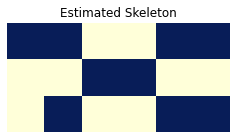

In [612]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mocap_skeleton.pdf') as pdf:
    fig = plt.figure(figsize=(4,2))
    sns.heatmap(np.stack(masks), cmap="YlGnBu", cbar=False)
    plt.axis('off')
    plt.title('Estimated Skeleton')
    pdf.savefig(fig, bbox_inches="tight")

In [587]:
y = X3.reshape(batch_size,-1)[:,0]
path = pr_model.path(X, y)

Initialized dense model in 1000 epochs, val loss 4.99e-03, regularization 1.36e-01
Lambda = 4.99e-04, selected 6 features in 15 epochs
val_objective 7.24e-01, val_loss 7.24e-01, regularization 1.39e-01
Lambda = 5.09e-04, selected 6 features in 11 epochs
val_objective 8.10e-01, val_loss 8.10e-01, regularization 1.88e-01
Lambda = 5.19e-04, selected 6 features in 85 epochs
val_objective 3.74e-02, val_loss 3.68e-02, regularization 1.07e+00
Lambda = 5.29e-04, selected 6 features in 10 epochs
val_objective 3.84e-02, val_loss 3.78e-02, regularization 1.08e+00
Lambda = 5.40e-04, selected 6 features in 10 epochs
val_objective 3.81e-02, val_loss 3.75e-02, regularization 1.09e+00
Lambda = 5.51e-04, selected 6 features in 10 epochs
val_objective 3.84e-02, val_loss 3.78e-02, regularization 1.08e+00
Lambda = 5.62e-04, selected 6 features in 10 epochs
val_objective 3.86e-02, val_loss 3.80e-02, regularization 1.08e+00
Lambda = 5.73e-04, selected 6 features in 10 epochs
val_objective 3.83e-02, val_loss

Lambda = 2.16e-03, selected 6 features in 10 epochs
val_objective 2.43e-02, val_loss 2.20e-02, regularization 1.07e+00
Lambda = 2.20e-03, selected 6 features in 10 epochs
val_objective 2.42e-02, val_loss 2.19e-02, regularization 1.07e+00
Lambda = 2.25e-03, selected 6 features in 10 epochs
val_objective 2.42e-02, val_loss 2.17e-02, regularization 1.07e+00
Lambda = 2.29e-03, selected 6 features in 10 epochs
val_objective 2.41e-02, val_loss 2.16e-02, regularization 1.07e+00
Lambda = 2.34e-03, selected 6 features in 10 epochs
val_objective 2.40e-02, val_loss 2.15e-02, regularization 1.07e+00
Lambda = 2.38e-03, selected 6 features in 10 epochs
val_objective 2.40e-02, val_loss 2.14e-02, regularization 1.07e+00
Lambda = 2.43e-03, selected 6 features in 10 epochs
val_objective 2.39e-02, val_loss 2.13e-02, regularization 1.07e+00
Lambda = 2.48e-03, selected 6 features in 10 epochs
val_objective 2.38e-02, val_loss 2.12e-02, regularization 1.07e+00
Lambda = 2.53e-03, selected 6 features in 10 epo

Lambda = 8.99e-03, selected 6 features in 10 epochs
val_objective 2.67e-02, val_loss 1.71e-02, regularization 1.07e+00
Lambda = 9.17e-03, selected 6 features in 10 epochs
val_objective 2.69e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.35e-03, selected 6 features in 10 epochs
val_objective 2.71e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.54e-03, selected 6 features in 10 epochs
val_objective 2.72e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.73e-03, selected 6 features in 10 epochs
val_objective 2.74e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.92e-03, selected 6 features in 10 epochs
val_objective 2.76e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 1.01e-02, selected 6 features in 10 epochs
val_objective 2.78e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 1.03e-02, selected 6 features in 10 epochs
val_objective 2.80e-02, val_loss 1.69e-02, regularization 1.07e+00
Lambda = 1.05e-02, selected 6 features in 10 epo

Lambda = 3.67e-02, selected 6 features in 10 epochs
val_objective 5.51e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.74e-02, selected 6 features in 10 epochs
val_objective 5.59e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.81e-02, selected 6 features in 10 epochs
val_objective 5.66e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.89e-02, selected 6 features in 10 epochs
val_objective 5.74e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.97e-02, selected 6 features in 10 epochs
val_objective 5.83e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 4.05e-02, selected 6 features in 10 epochs
val_objective 5.91e-02, val_loss 1.58e-02, regularization 1.07e+00
Lambda = 4.13e-02, selected 6 features in 10 epochs
val_objective 5.99e-02, val_loss 1.58e-02, regularization 1.07e+00
Lambda = 4.21e-02, selected 6 features in 10 epochs
val_objective 6.08e-02, val_loss 1.58e-02, regularization 1.07e+00
Lambda = 4.30e-02, selected 6 features in 10 epo

Lambda = 1.50e-01, selected 6 features in 10 epochs
val_objective 1.73e-01, val_loss 1.49e-02, regularization 1.06e+00
Lambda = 1.53e-01, selected 6 features in 10 epochs
val_objective 1.76e-01, val_loss 1.49e-02, regularization 1.06e+00
Lambda = 1.56e-01, selected 6 features in 10 epochs
val_objective 1.79e-01, val_loss 1.49e-02, regularization 1.06e+00
Lambda = 1.59e-01, selected 6 features in 10 epochs
val_objective 1.83e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.62e-01, selected 6 features in 10 epochs
val_objective 1.86e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.65e-01, selected 6 features in 10 epochs
val_objective 1.89e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.68e-01, selected 6 features in 10 epochs
val_objective 1.93e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.72e-01, selected 6 features in 10 epochs
val_objective 1.96e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.75e-01, selected 6 features in 10 epo

Lambda = 6.10e-01, selected 6 features in 10 epochs
val_objective 6.33e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.22e-01, selected 6 features in 10 epochs
val_objective 6.45e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.35e-01, selected 6 features in 10 epochs
val_objective 6.57e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.47e-01, selected 6 features in 10 epochs
val_objective 6.70e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.60e-01, selected 6 features in 10 epochs
val_objective 6.82e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.74e-01, selected 6 features in 10 epochs
val_objective 6.95e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.87e-01, selected 6 features in 10 epochs
val_objective 7.08e-01, val_loss 1.51e-02, regularization 1.01e+00
Lambda = 7.01e-01, selected 6 features in 10 epochs
val_objective 7.21e-01, val_loss 1.51e-02, regularization 1.01e+00
Lambda = 7.15e-01, selected 6 features in 10 epo

Lambda = 2.44e+00, selected 4 features in 10 epochs
val_objective 2.25e+00, val_loss 2.45e-02, regularization 9.14e-01
Lambda = 2.49e+00, selected 4 features in 10 epochs
val_objective 2.29e+00, val_loss 2.50e-02, regularization 9.12e-01
Lambda = 2.54e+00, selected 4 features in 10 epochs
val_objective 2.34e+00, val_loss 2.55e-02, regularization 9.10e-01
Lambda = 2.59e+00, selected 4 features in 10 epochs
val_objective 2.38e+00, val_loss 2.56e-02, regularization 9.08e-01
Lambda = 2.64e+00, selected 4 features in 10 epochs
val_objective 2.42e+00, val_loss 2.60e-02, regularization 9.05e-01
Lambda = 2.69e+00, selected 4 features in 10 epochs
val_objective 2.46e+00, val_loss 2.66e-02, regularization 9.02e-01
Lambda = 2.75e+00, selected 4 features in 10 epochs
val_objective 2.50e+00, val_loss 2.74e-02, regularization 8.99e-01
Lambda = 2.80e+00, selected 4 features in 10 epochs
val_objective 2.54e+00, val_loss 2.82e-02, regularization 8.96e-01
Lambda = 2.86e+00, selected 4 features in 10 epo

Lambda = 1.04e+01, selected 5 features in 10 epochs
val_objective 6.15e-02, val_loss 3.13e-03, regularization 5.63e-03
Lambda = 1.06e+01, selected 5 features in 10 epochs
val_objective 6.26e-02, val_loss 3.13e-03, regularization 5.63e-03
Lambda = 1.08e+01, selected 5 features in 10 epochs
val_objective 6.38e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.10e+01, selected 5 features in 10 epochs
val_objective 6.50e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.12e+01, selected 5 features in 10 epochs
val_objective 6.62e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.14e+01, selected 5 features in 10 epochs
val_objective 6.75e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.17e+01, selected 5 features in 10 epochs
val_objective 6.87e-02, val_loss 3.14e-03, regularization 5.62e-03
Lambda = 1.19e+01, selected 5 features in 10 epochs
val_objective 7.00e-02, val_loss 3.14e-03, regularization 5.62e-03
Lambda = 1.21e+01, selected 5 features in 10 epo

Lambda = 4.23e+01, selected 4 features in 10 epochs
val_objective 2.34e-01, val_loss 3.29e-03, regularization 5.46e-03
Lambda = 4.31e+01, selected 4 features in 10 epochs
val_objective 2.39e-01, val_loss 3.29e-03, regularization 5.46e-03
Lambda = 4.40e+01, selected 4 features in 10 epochs
val_objective 2.43e-01, val_loss 3.30e-03, regularization 5.46e-03
Lambda = 4.48e+01, selected 4 features in 10 epochs
val_objective 2.48e-01, val_loss 3.30e-03, regularization 5.45e-03
Lambda = 4.57e+01, selected 4 features in 10 epochs
val_objective 2.52e-01, val_loss 3.31e-03, regularization 5.45e-03
Lambda = 4.66e+01, selected 4 features in 10 epochs
val_objective 2.57e-01, val_loss 3.31e-03, regularization 5.44e-03
Lambda = 4.76e+01, selected 4 features in 10 epochs
val_objective 2.62e-01, val_loss 3.32e-03, regularization 5.44e-03
Lambda = 4.85e+01, selected 4 features in 10 epochs
val_objective 2.67e-01, val_loss 3.33e-03, regularization 5.44e-03
Lambda = 4.95e+01, selected 4 features in 10 epo

Lambda = 2.14e+02, selected 2 features in 11 epochs
val_objective 1.03e+00, val_loss 7.58e-03, regularization 4.79e-03
Lambda = 2.19e+02, selected 2 features in 11 epochs
val_objective 1.05e+00, val_loss 7.67e-03, regularization 4.78e-03
Lambda = 2.23e+02, selected 2 features in 11 epochs
val_objective 1.07e+00, val_loss 7.76e-03, regularization 4.77e-03
Lambda = 2.27e+02, selected 2 features in 11 epochs
val_objective 1.09e+00, val_loss 7.85e-03, regularization 4.76e-03
Lambda = 2.32e+02, selected 2 features in 11 epochs
val_objective 1.11e+00, val_loss 7.98e-03, regularization 4.75e-03
Lambda = 2.37e+02, selected 2 features in 11 epochs
val_objective 1.13e+00, val_loss 8.17e-03, regularization 4.73e-03
Lambda = 2.41e+02, selected 2 features in 11 epochs
val_objective 1.15e+00, val_loss 8.38e-03, regularization 4.72e-03
Lambda = 2.46e+02, selected 2 features in 11 epochs
val_objective 1.16e+00, val_loss 8.75e-03, regularization 4.69e-03
Lambda = 2.51e+02, selected 2 features in 10 epo

Lambda = 1.07e+03, selected 1 features in 11 epochs
val_objective 3.75e+00, val_loss 3.34e-02, regularization 3.49e-03
Lambda = 1.09e+03, selected 1 features in 11 epochs
val_objective 3.80e+00, val_loss 3.39e-02, regularization 3.47e-03
Lambda = 1.11e+03, selected 1 features in 11 epochs
val_objective 3.86e+00, val_loss 3.43e-02, regularization 3.45e-03
Lambda = 1.13e+03, selected 1 features in 11 epochs
val_objective 3.92e+00, val_loss 3.47e-02, regularization 3.43e-03
Lambda = 1.15e+03, selected 1 features in 11 epochs
val_objective 3.97e+00, val_loss 3.51e-02, regularization 3.41e-03
Lambda = 1.18e+03, selected 1 features in 11 epochs
val_objective 4.03e+00, val_loss 3.54e-02, regularization 3.40e-03
Lambda = 1.20e+03, selected 1 features in 11 epochs
val_objective 4.10e+00, val_loss 3.55e-02, regularization 3.38e-03
Lambda = 1.22e+03, selected 1 features in 11 epochs
val_objective 4.16e+00, val_loss 3.53e-02, regularization 3.37e-03
Lambda = 1.25e+03, selected 1 features in 11 epo

In [584]:
mask

tensor([False,  True, False, False,  True,  True])

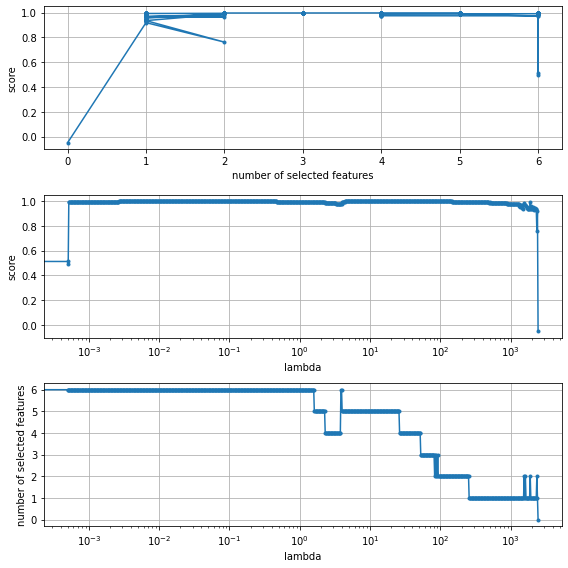

In [588]:
plot_path(pr_model, path, X, y)

In [537]:
out = [ ]
for i in range(3):
    y = X3.reshape(batch_size,-1)[:,i]
    clf = Lasso(alpha=0.0001, normalize=True, max_iter=5000).fit(X, y)
    coef = clf.coef_.reshape(2,3)
    out.append(coef)

In [538]:
out

[array([[0.97761995, 0.        , 0.02464853],
        [0.01462337, 0.01066853, 0.00965156]], dtype=float32),
 array([[-0.        ,  0.8906622 ,  0.        ],
        [-0.00671231,  0.10219645,  0.        ]], dtype=float32),
 array([[-8.3120971e-04, -0.0000000e+00,  9.1457218e-01],
        [-3.9391242e-02, -0.0000000e+00,  7.4293330e-02]], dtype=float32)]

In [532]:
out[2]

array([[ 0.        , -0.        ,  0.9751262 ,  0.        , -0.        ,
        -0.        ,  0.01629186, -0.        ],
       [ 0.        ,  0.09069263,  0.01562128,  0.00903758, -0.        ,
         0.        ,  0.0119777 , -0.        ]], dtype=float32)

In [ ]:
out[3]

In [ ]:
out[6]

In [ ]:
z[:,1]

In [399]:
z.shape

torch.Size([4364, 6, 8])

In [98]:
mu.shape

torch.Size([2560, 6, 8])

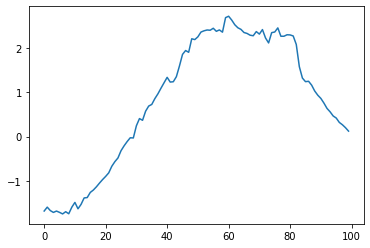

In [289]:
plt.plot(mu[start:end,0,6].detach().numpy())
# plt.plot(z[:300,0,1].detach().numpy())

In [85]:
mu[:300,0].detach().numpy()

array([[-0.04243672, -0.3902921 , -1.0003277 , ..., -0.03542842,
        -1.008788  ,  0.05361128],
       [-0.05133411, -0.37694418, -1.0310696 , ..., -0.03682287,
        -0.9230186 ,  0.04193455],
       [-0.05191309, -0.37330574, -1.0307329 , ..., -0.03854215,
        -0.89342284,  0.04012896],
       ...,
       [-0.15150769, -0.25223267, -0.26817167, ..., -0.02855502,
         1.2452265 , -0.09477242],
       [-0.14803408, -0.25256082, -0.2363221 , ..., -0.03004931,
         1.3152888 , -0.09650569],
       [-0.14322773, -0.24922717, -0.16228047, ..., -0.03252527,
         1.3384143 , -0.0949945 ]], dtype=float32)

In [271]:
batch['s1']['xt'][300:600,0]

tensor([[ 0.3393,  1.5028,  1.4732,  ..., -0.3033,  0.7817,  0.1446],
        [ 0.3666,  1.5100,  1.4818,  ..., -0.3182,  0.7310, -0.0394],
        [ 0.3787,  1.5057,  1.4906,  ..., -0.2822,  0.6649, -0.4909],
        ...,
        [ 0.2765,  0.1853,  1.0480,  ...,  1.4823, -1.8312, -0.7831],
        [ 0.2545,  0.1808,  1.0590,  ...,  1.6312, -1.8080, -1.3100],
        [ 0.2428,  0.1972,  1.0692,  ...,  1.7169, -1.8202, -1.9186]])

In [308]:
batch['s1']['ct'][0:316,0]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [49]:
xt = (data.data['xt'] - data.data['xt'].mean(0))/data.data['xt'].std(0)

In [31]:
X = (data.data['xt'] - data.data['xt'].mean(0))/data.data['xt'].std(0)

In [43]:
np.square(X).mean(0).sum()

62.00000000000001

(array([1.000e+00, 1.600e+01, 9.900e+01, 5.310e+02, 1.032e+03, 1.112e+03,
        9.330e+02, 4.410e+02, 1.580e+02, 4.600e+01]),
 array([-3.89609897, -3.18725706, -2.47841514, -1.76957322, -1.0607313 ,
        -0.35188938,  0.35695253,  1.06579445,  1.77463637,  2.48347829,
         3.19232021]),
 <BarContainer object of 10 artists>)

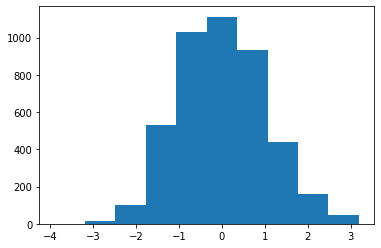

In [37]:
plt.hist(X[:,3])

In [33]:
X.shape

(4369, 62)

In [19]:
data.data['ct']

array([[ 0.],
       [ 0.],
       [ 0.],
       ...,
       [11.],
       [11.],
       [11.]])

In [26]:
data.__getitem__(5)['s1']['xt'].shape

torch.Size([4, 62])